In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144
import tensorflow as tf
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Parameters
learning_rate = 0.01
batch_size = 100
tbatch_size = 50
display_step = 100
train_size = (1 - 0.8)
step_size = 3000
alpha = 0.0001
momentum = 0.99

# Network Parameters
n_hidden_1 = 32
n_hidden_2 = 32

#### data load and preprocessing

In [3]:
df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

In [4]:
sex_dum = pd.get_dummies(df['Sex'])
df_proc = pd.concat((df,sex_dum),axis=1)
df_proc = df_proc.drop('Sex',axis=1)
df_proc = df_proc.drop('female',axis=1)

sex_dum = pd.get_dummies(test_df['Sex'])
test_df_proc = pd.concat((test_df,sex_dum),axis=1)
test_df_proc = test_df_proc.drop('Sex',axis=1)
test_df_proc = test_df_proc.drop('female',axis=1)

In [5]:
emb_dum = pd.get_dummies(df['Embarked'])
df_proc = pd.concat((df_proc,emb_dum),axis=1)
df_proc = df_proc.drop('Embarked',axis=1)
df_proc = df_proc.drop('S',axis=1)

emb_dum = pd.get_dummies(test_df['Embarked'])
test_df_proc = pd.concat((test_df_proc,emb_dum),axis=1)
test_df_proc = test_df_proc.drop('Embarked',axis=1)
test_df_proc = test_df_proc.drop('S',axis=1)

In [6]:
def name_classifier(name_df):    
    name_class_df = pd.DataFrame(columns={'miss','mrs','master','mr'})
    
    for name in name_df:        
        if 'Miss' in name:
            df = pd.DataFrame([[1,0,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Mrs' in name:
            df = pd.DataFrame([[0,1,0,0]],columns={'miss','mrs','master','mr'})
        elif 'Master' in name:
            df = pd.DataFrame([[0,0,1,0]],columns={'miss','mrs','master','mr'})
        elif 'Mr' in name:
            df = pd.DataFrame([[0,0,0,1]],columns={'miss','mrs','master','mr'})
        else :
            df = pd.DataFrame([[0,0,0,0]],columns={'miss','mrs','master','mr'})
        name_class_df = name_class_df.append(df,ignore_index=True)        
    return name_class_df

In [7]:
nam_dum = name_classifier(df.Name)
df_proc = pd.concat((df_proc,nam_dum),axis=1)
df_proc = df_proc.drop('Name',axis=1)

nam_dum = name_classifier(test_df.Name)
test_df_proc = pd.concat((test_df_proc,nam_dum),axis=1)
test_df_proc = test_df_proc.drop('Name',axis=1)

In [8]:
df_proc.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
male             0
C                0
Q                0
master           0
miss             0
mr               0
mrs              0
dtype: int64

In [9]:
labelEncoder = preprocessing.LabelEncoder()
df_proc['Cabin'] = labelEncoder.fit_transform(df_proc['Cabin'].astype(str))
test_df_proc['Cabin'] = labelEncoder.fit_transform(test_df_proc['Cabin'].astype(str))

In [10]:
x_np = np.array(df_proc.drop(['Survived', 'Ticket'], axis=1).fillna(df.mean()))

In [11]:
d = df_proc[['Survived']].to_dict('record')
vectorizer = DictVectorizer(sparse=False)
y_np = vectorizer.fit_transform(d)

label = np.zeros((y_np.shape[0], y_np.max().astype(int) + 1))
for index, flag in enumerate(y_np):
    label[index][flag.astype(int)] = 1

In [12]:
train_x, valid_x, train_y, valid_y = train_test_split(x_np, label, test_size=train_size)

num_input = train_x.shape[1]
num_classes = 2

#### Create TF model

In [13]:
# tf Graph input
X = tf.placeholder(tf.float64, [None, num_input])
Y = tf.placeholder(tf.float64, [None, num_classes])
keep_prob = tf.placeholder(tf.float64)

In [14]:
# Create model
def multilayer_perceptron(x):
    drop1 = tf.layers.dropout(x, keep_prob, training=True)
    layer1 = tf.layers.dense(drop1,
                             n_hidden_1,
                             activation=None,
                             use_bias=True,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=num_input**-0.5),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))
    bn1 = tf.layers.batch_normalization(layer1, training=True, momentum=momentum)
    act1 = tf.nn.relu(bn1)
    drop2 = tf.layers.dropout(act1, keep_prob, training=True)
    layer2 = tf.layers.dense(drop2,
                             n_hidden_2,
                             activation=None,
                             use_bias=True,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=n_hidden_1**-0.5),
                             kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))
    bn2 = tf.layers.batch_normalization(layer2, training=True, momentum=momentum)
    act2 = tf.nn.relu(bn2)
    drop3 = tf.layers.dropout(act2, keep_prob, training=True)
    out_layer = tf.layers.dense(drop3,
                                num_classes,
                                activation=None,
                                use_bias=True,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=n_hidden_2**-0.5),
                                kernel_regularizer=tf.contrib.layers.l2_regularizer(alpha))
    return out_layer

In [15]:
# Construct model
logits = multilayer_perceptron(X)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)

# Evaluate model
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1)), tf.float64))

#### Trainig

In [16]:
init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:    
    metrics = {
        'train_loss':[],
        'train_acc':[],
        'test_loss':[],
        'test_acc':[]
    }
    
    # Run the initializer
    sess.run(init)

    for step in range(step_size):
        ind = np.random.choice(batch_size, batch_size)
        batch_x = train_x[ind]
        batch_y = train_y[ind]
        ind = np.random.choice(tbatch_size, tbatch_size)
        batch_tx = valid_x[ind]
        batch_ty = valid_y[ind]
        
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob:0.3})
        if step % display_step == 0 or step == 1:
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.0})
            print("Step " + str(step) + " Train loss: %0.5f, Train acc: %0.5f" % (loss, acc))
            metrics['train_loss'].append(loss)
            metrics['train_acc'].append(acc)
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_tx, Y: batch_ty, keep_prob: 0.0})
            print("Step " + str(step) + " Test loss: %0.5f, Test acc: %0.5f" % (loss, acc))
            metrics['test_loss'].append(loss)
            metrics['test_acc'].append(acc)

    print("Optimization Finished!")

    # Calculate accuracy
    print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: x_np, Y: label, keep_prob: 0.0}))
    
    saver.save(sess, "./model/model.ckpt")

Step 0 Train loss: 0.76766, Train acc: 0.49000
Step 0 Test loss: 0.78897, Test acc: 0.42000
Step 1 Train loss: 0.74088, Train acc: 0.49000
Step 1 Test loss: 0.85710, Test acc: 0.28000
Step 100 Train loss: 0.59089, Train acc: 0.72000
Step 100 Test loss: 0.71347, Test acc: 0.70000
Step 200 Train loss: 0.59241, Train acc: 0.71000
Step 200 Test loss: 0.59871, Test acc: 0.72000
Step 300 Train loss: 0.60352, Train acc: 0.67000
Step 300 Test loss: 0.59537, Test acc: 0.84000
Step 400 Train loss: 0.59235, Train acc: 0.69000
Step 400 Test loss: 0.54136, Test acc: 0.78000
Step 500 Train loss: 0.48783, Train acc: 0.77000
Step 500 Test loss: 0.54247, Test acc: 0.72000
Step 600 Train loss: 0.41416, Train acc: 0.85000
Step 600 Test loss: 0.41103, Test acc: 0.82000
Step 700 Train loss: 0.34642, Train acc: 0.90000
Step 700 Test loss: 0.41936, Test acc: 0.82000
Step 800 Train loss: 0.37822, Train acc: 0.83000
Step 800 Test loss: 0.27242, Test acc: 0.94000
Step 900 Train loss: 0.34773, Train acc: 0.88000

Text(0,0.5,'Loss')

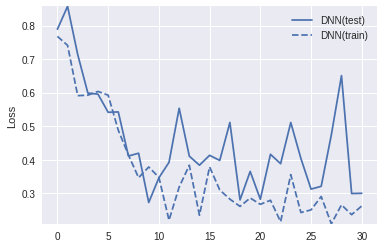

In [17]:
snc = sns.color_palette()

plt.plot(metrics['test_loss'], color=snc[0])
plt.plot(metrics['train_loss'], color=snc[0], ls='--')
plt.ylim(min(min(metrics['test_loss']), min(metrics['train_loss'])), max(max(metrics['test_loss']), max(metrics['train_loss'])))
plt.legend(['DNN(test)', 'DNN(train)'])
plt.ylabel('Loss')

In [18]:
sess.close()
sess=tf.InteractiveSession()

init = tf.global_variables_initializer()
sess.run(init)

saver.restore(sess, "./model/model.ckpt")

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


#### predict

In [19]:
t = np.array(test_df_proc.drop(['Ticket'], axis=1).fillna(df.mean()))
answer = sess.run(prediction, feed_dict={X: t, keep_prob: 0.0})

In [20]:
predict = np.argmax(answer, axis=1)

In [21]:
PassengerId = np.array(test_df["PassengerId"]).astype(int)
my_solution = pd.DataFrame(predict, PassengerId, columns = ["Survived"]) 
my_solution.to_csv("./data/pred.csv", index_label = ["PassengerId"])